In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import datetime
import pandas as pd
from pytz import utc
import os
import mlflow
import numpy as np

# mlflow imports
from mlflow.models.signature import infer_signature

# sklearn imports
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# oma_tracking imports
from oma_tracking.data.utils import read_simulations_csv_files
from oma_tracking.data import make_dataset
from oma_tracking.data.preprocessing import AngleTransformer, sin_cos_angle_inputs
import oma_tracking.models.mlflow_functions as mlflow_f


from dotenv import load_dotenv
load_dotenv()

True

In [3]:
start =  datetime.datetime(2022,11,1,tzinfo=utc)
stop  = datetime.datetime(2023,5,4,tzinfo=utc)
location = 'nw2d01'
name_location = 'NW2_D01'

# Data Paths
data_root = "../../../"
data_path = data_root + "data/nw2/raw/nw2d01_" + start.strftime("%Y%m%d") + "_" + stop.strftime("%Y%m%d") + ".parquet"
mvbc_path = data_root + "data/nw2/mvbc_data.parquet"
tracked_frequencies_path = data_root + "data/nw2/tracked_modes/" + location + ".parquet"
simulations_data_path = data_root + "data/nw2/simulations/" + location + "/"

# Get all the data
data = pd.read_parquet(data_path)
mvbc_data = pd.read_parquet(mvbc_path)
tracked_frequencies = pd.read_parquet(tracked_frequencies_path)
simulation_data = read_simulations_csv_files(simulations_data_path + "eigen_frequencies/")
simulation_shifts = read_simulations_csv_files(simulations_data_path + "mean_shifts/")
simulation_errors = pd.read_csv(simulations_data_path + "errors/Errors_No_scour.csv", index_col=0)

In [4]:
weather_inputs = make_dataset.get_weather_subset(mvbc_data)
scada_inputs = make_dataset.get_scada_subset(data)

inputs = \
    pd.concat(
        [
            weather_inputs,
            scada_inputs
        ],
        axis=1
    )

prediction_params = \
    tracked_frequencies 

In [5]:
mode = 'SS1'
target = prediction_params[mode]
np.var(target)

7.791153946693803e-06

In [6]:
import xgboost as xgb

y = prediction_params[mode].dropna()
X = inputs.loc[y.index].dropna()
y = y.loc[X.index]
X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size=0.2, random_state=42)

xgb_regressor = xgb.XGBRegressor()
xgb_regressor.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [7]:
import numpy as np
from xgboost import XGBRegressor
from oma_tracking.models.virtual_ensemble import VirtualEnsembleXGB

# Example usage
n_estimators = 50

xgb_model = XGBRegressor(n_estimators=n_estimators)
xgb_model.fit(X_train, y_train)

n_submodels = int(n_estimators/2)
ensemble_model = VirtualEnsembleXGB(xgb_model, n_submodels)
predictions = ensemble_model.predict(X)
mean_predictions = ensemble_model.mean_predictions(X)
std_predictions = ensemble_model.std_predictions(X)


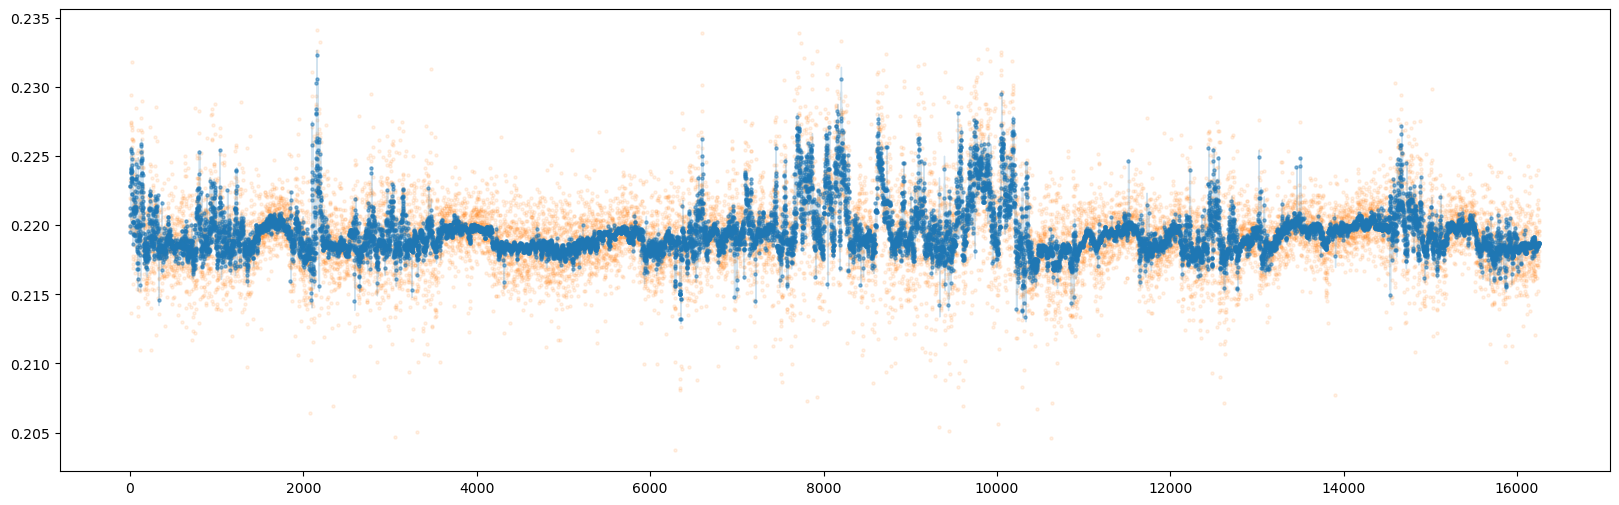

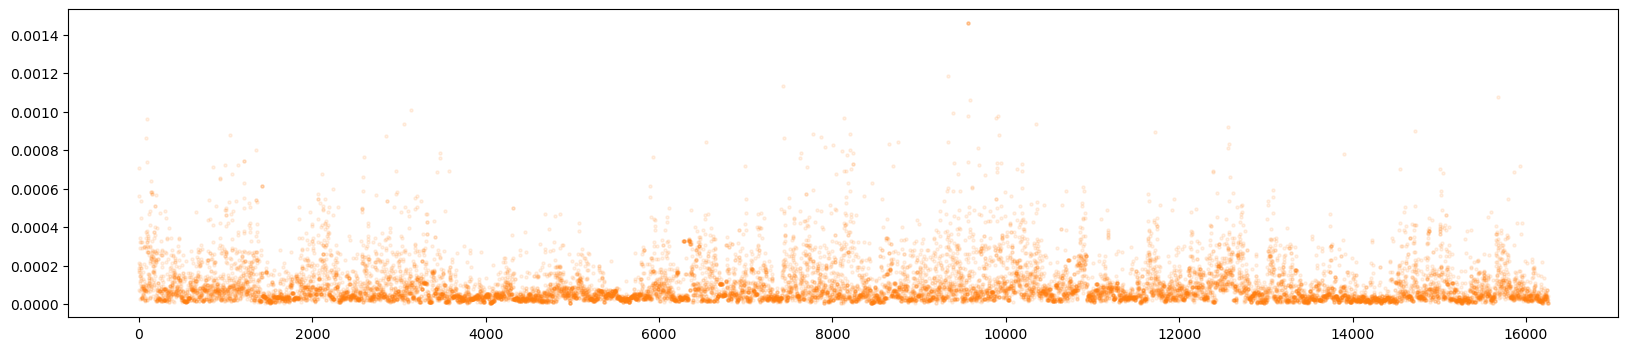

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,6))
plt.scatter(range(len(y)), y, alpha=0.1, color='tab:orange', s=5)
plt.scatter(range(len(mean_predictions)), mean_predictions, alpha=0.5, s=5)
plt.fill_between(range(len(std_predictions)), mean_predictions-std_predictions, mean_predictions+std_predictions, alpha = 0.2, color = 'tab:blue')
#plt.scatter(range(len(xgb_model.predict(X))), xgb_model.predict(X), alpha=0.5)
plt.show()
plt.figure(figsize=(20,4))
plt.scatter(range(len(std_predictions)), std_predictions, alpha=0.1, color='tab:orange', s=5)


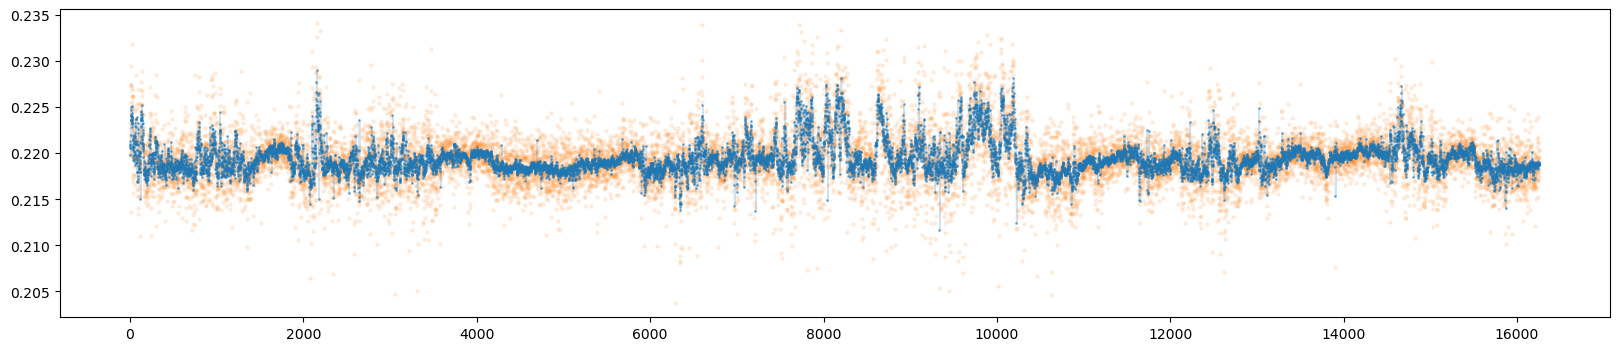

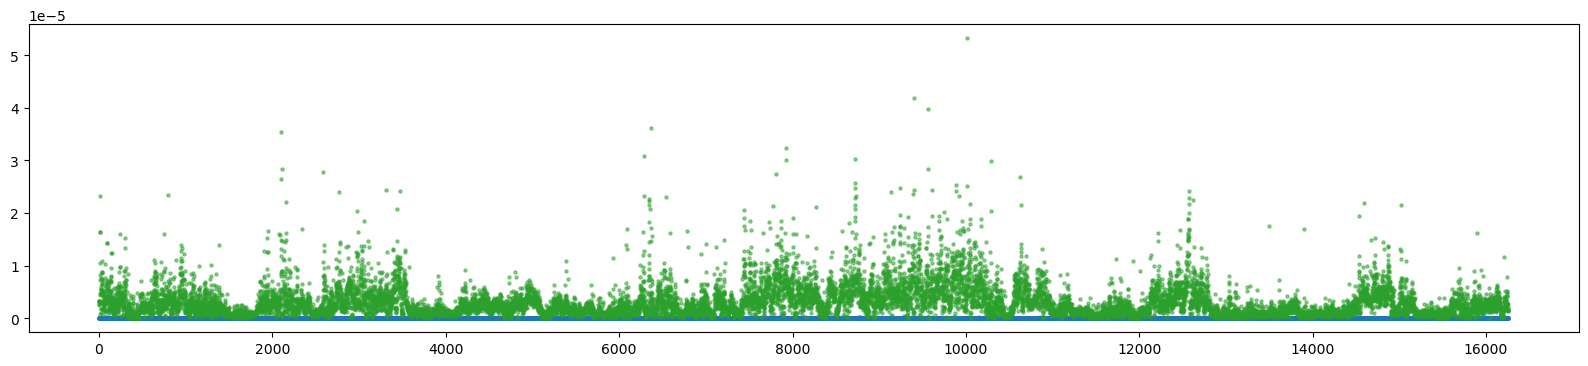

In [43]:
import catboost as cb

model = cb.CatBoostRegressor(iterations=1000, learning_rate=0.2, 
                          loss_function='RMSEWithUncertainty', posterior_sampling=True, 
                          verbose=False, random_seed=0)
model.fit(X_train, y_train)
preds = model.virtual_ensembles_predict(X, prediction_type='TotalUncertainty', 
                                        virtual_ensembles_count=100)

mean_preds = preds[:,0] # mean values predicted by a virtual ensemble
knowledge = preds[:,1] # knowledge uncertainty predicted by a virtual ensemble
data = preds[:,2] # average estimated data uncertainty

plt.figure(figsize=(20,4))
plt.scatter(range(len(y)), y, alpha=0.1, color='tab:orange', s=5)
plt.scatter(range(len(y)), mean_preds, alpha=0.5, color='tab:blue', s=1)
plt.fill_between(range(len(y)), mean_preds-knowledge, mean_preds+knowledge, alpha = 0.2, color = 'tab:blue')
#plt.fill_between(range(len(y)), mean_preds-data, mean_preds+data, alpha = 0.2, color = 'tab:green')

#plt.scatter(range(len(mean_predictions)), mean_predictions, alpha=0.1, s=5, color = 'tab:green')
#plt.fill_between(range(len(std_predictions)), mean_predictions-std_predictions, mean_predictions+std_predictions, alpha = 0.1, color = 'tab:green')

plt.show()

plt.figure(figsize=(20,4))
plt.scatter(range(len(y)), knowledge, alpha=0.5, color='tab:blue',s=5)
plt.scatter(range(len(y)), data, alpha=0.5, color='tab:green',s=5)

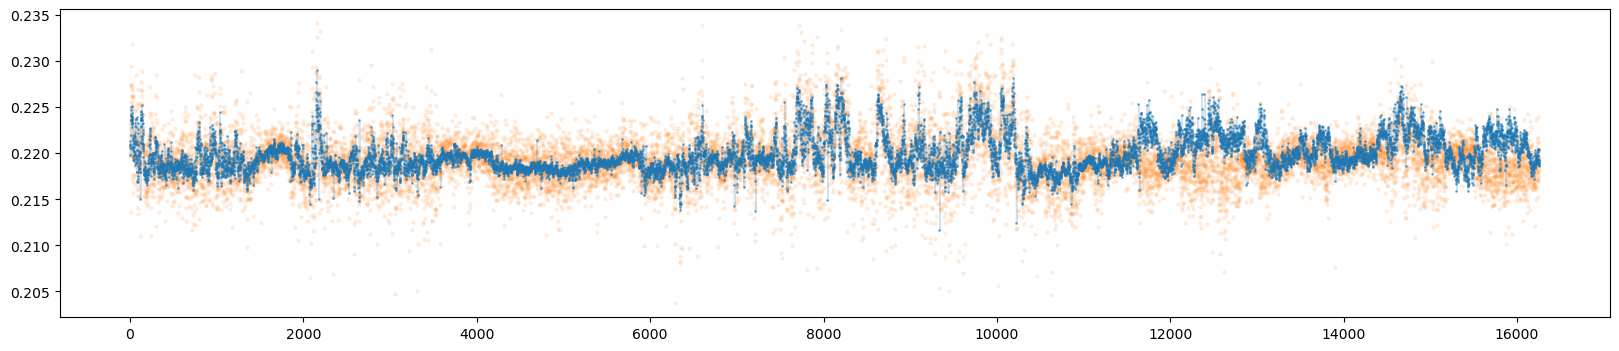

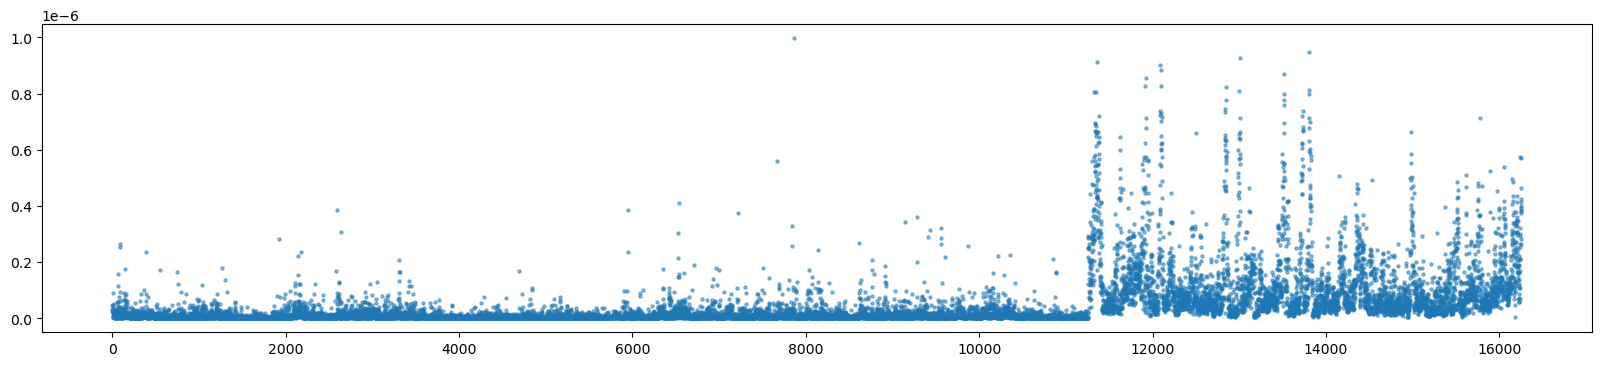

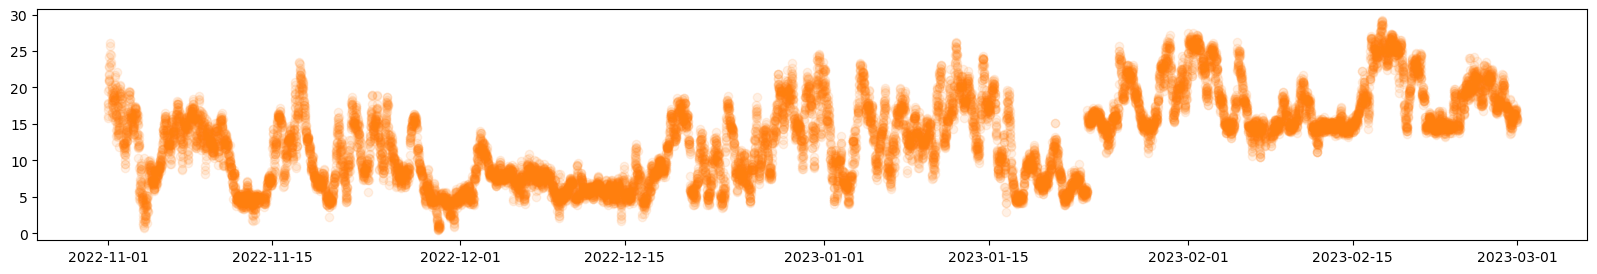

In [44]:
X_transformed = X.copy()
columns = -2
X_transformed.iloc[-5000:, columns] = X.iloc[-5000:, columns] + 10
#predictions = ensemble_model.predict(X_test*5)
preds = model.virtual_ensembles_predict(X_transformed, prediction_type='TotalUncertainty', 
                                        virtual_ensembles_count=100)

mean_preds = preds[:,0] # mean values predicted by a virtual ensemble
knowledge = preds[:,1] # knowledge uncertainty predicted by a virtual ensemble
data = preds[:,2] # average estimated data uncertainty

plt.figure(figsize=(20,4))
plt.scatter(range(len(y)), y, alpha=0.1, color='tab:orange', s=5)
plt.scatter(range(len(y)), mean_preds, alpha=0.5, color='tab:blue', s=1)
plt.fill_between(range(len(y)), mean_preds-knowledge, mean_preds+knowledge, alpha = 0.2, color = 'tab:blue')
#plt.fill_between(range(len(y)), mean_preds-data, mean_preds+data, alpha = 0.2, color = 'tab:green')
plt.show()

plt.figure(figsize=(20,4))
plt.scatter(range(len(y)), knowledge, alpha=0.5, color='tab:blue',s=5)
plt.show()

plt.figure(figsize=(20,3))
plt.scatter(X_transformed.index, X_transformed.iloc[:, columns], alpha=0.1, color='tab:orange')

In [46]:
from ngboost import NGBRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

ngb = NGBRegressor().fit(X_train, y_train)
Y_preds = ngb.predict(X_test)
Y_dists = ngb.pred_dist(X_test)

# test Mean Squared Error
test_MSE = mean_squared_error(Y_preds, y_test)
print('Test MSE', test_MSE)

# test Negative Log Likelihood
test_NLL = -Y_dists.logpdf(y_test).mean()
print('Test NLL', test_NLL)

[iter 0] loss=-4.4585 val_loss=0.0000 scale=1.0000 norm=0.5671
[iter 100] loss=-4.6959 val_loss=0.0000 scale=2.0000 norm=0.9635
[iter 200] loss=-4.7256 val_loss=0.0000 scale=1.0000 norm=0.4961
[iter 300] loss=-4.7409 val_loss=0.0000 scale=1.0000 norm=0.5026
[iter 400] loss=-4.7532 val_loss=0.0000 scale=1.0000 norm=0.5045
Test MSE 5.463372440129011e-06
Test NLL -4.728549325249459


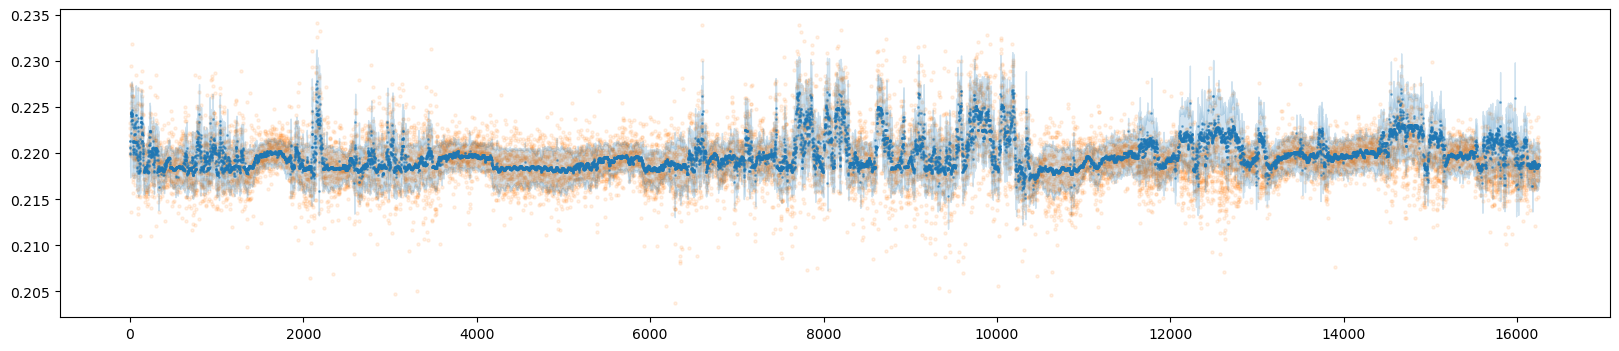

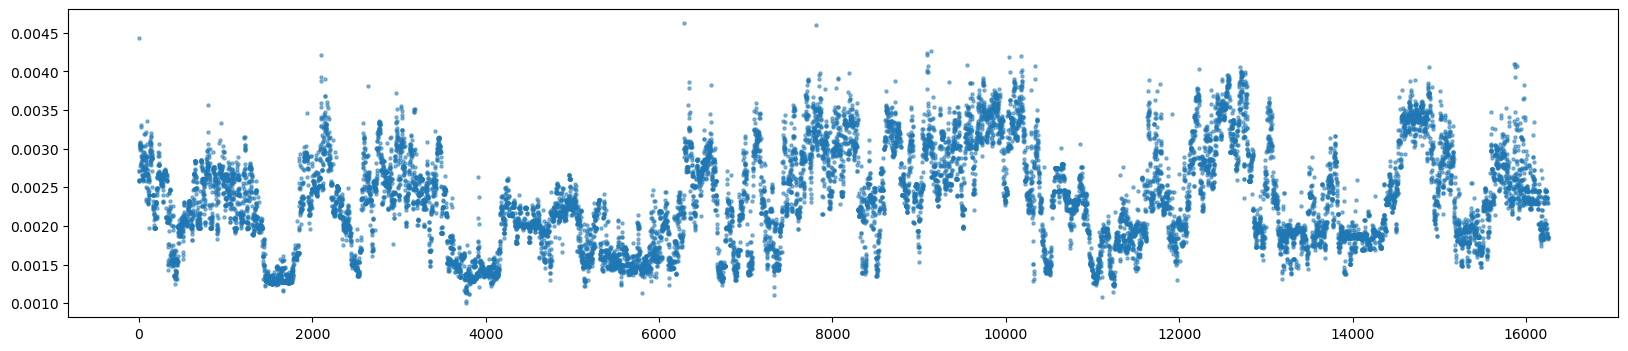

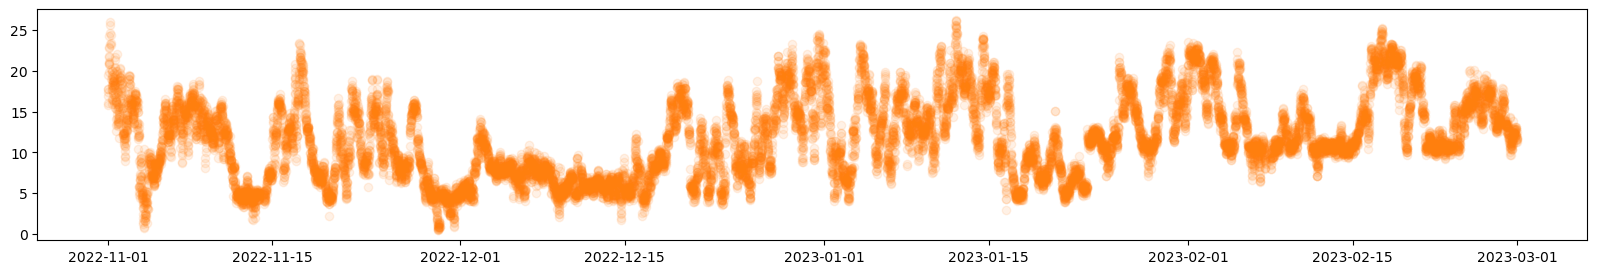

In [60]:
X_transformed = X.copy()
columns = -2
X_transformed.iloc[-5000:, columns] = X.iloc[-5000:, columns] + 6
#predictions = ensemble_model.predict(X_test*5)
preds = ngb.predict(X_transformed)
pred_dist = ngb.pred_dist(X_transformed)

plt.figure(figsize=(20,4))
plt.scatter(range(len(y)), y, alpha=0.1, color='tab:orange', s=5)
plt.scatter(range(len(y)), preds, alpha=0.5, color='tab:blue', s=1)
plt.fill_between(range(len(y)), pred_dist.params['loc']-pred_dist.params['scale'], pred_dist.params['loc']+pred_dist.params['scale'], alpha = 0.2, color = 'tab:blue')
#plt.fill_between(range(len(y)), mean_preds-data, mean_preds+data, alpha = 0.2, color = 'tab:green')
plt.show()

plt.figure(figsize=(20,4))
plt.scatter(range(len(y)), pred_dist.params['scale'], alpha=0.5, color='tab:blue',s=5)
plt.show()

plt.figure(figsize=(20,3))
plt.scatter(X_transformed.index, X_transformed.iloc[:, columns], alpha=0.1, color='tab:orange')

In [441]:
X.columns

Index(['mvbc_WandelaarBuoy_Wave_height',
       'mvbc_WandelaarBuoy_Sea_water_temperature',
       'mvbc_WandelaarMeasuringpile_Tide_TAW',
       'mvbc_WandelaarMeasuringpile_Air_pressure',
       'mvbc_WandelaarMeasuringpile_Air_temperature', 'mean_NW2_D01_rpm',
       'mean_NW2_D01_yaw', 'mean_NW2_D01_pitch', 'mean_NW2_D01_power',
       'mean_NW2_D01_windspeed', 'mean_NW2_D01_winddirection'],
      dtype='object')

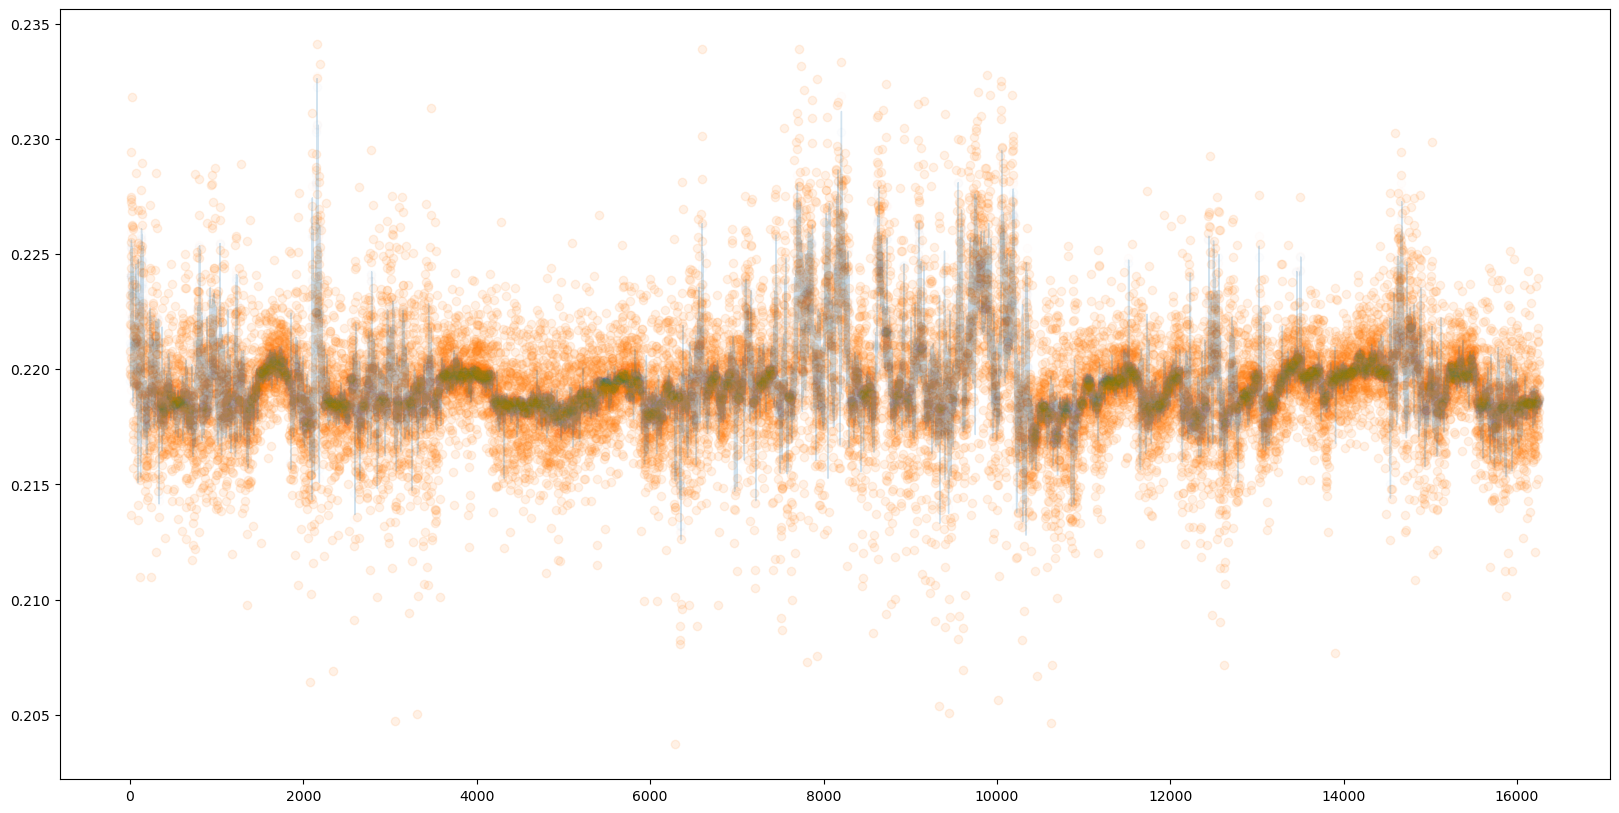

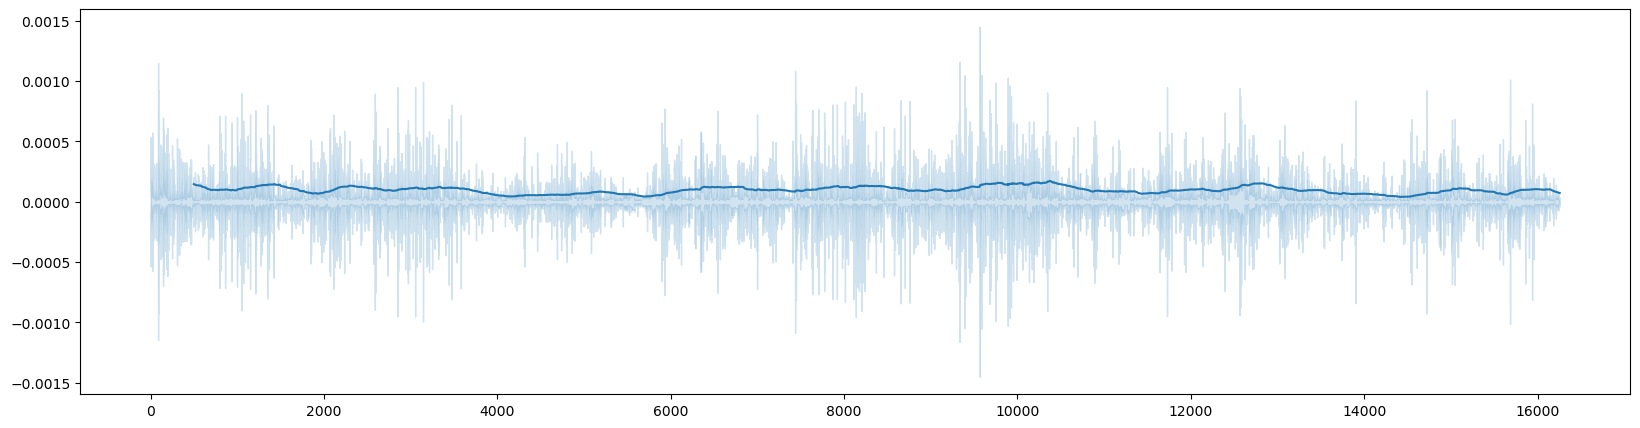

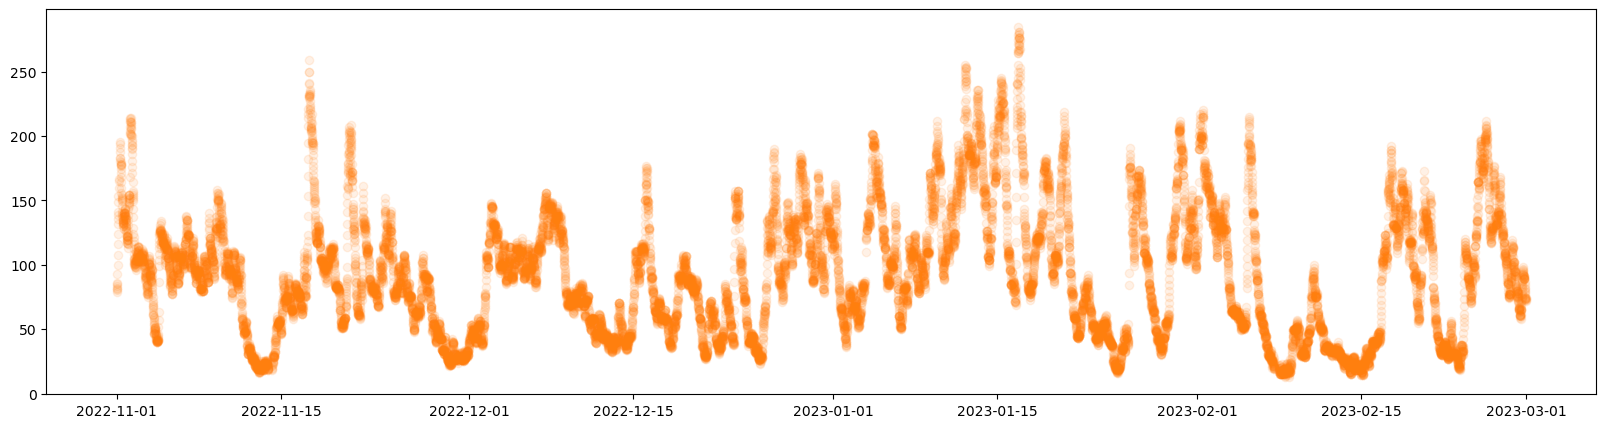

In [450]:
X_transformed = X.copy()
columns = 0
X_transformed.iloc[-5000:, columns] = X.iloc[-5000:, columns] + 0
#predictions = ensemble_model.predict(X_test*5)
mean_predictions = ensemble_model.mean_predictions(X_transformed)
std_predictions = ensemble_model.std_predictions(X_transformed)

plt.figure(figsize=(20,10))
plt.scatter(range(len(y)), y, alpha=0.1, color='tab:orange')
plt.scatter(range(len(mean_predictions)), mean_predictions, alpha=0.01)
plt.fill_between(range(len(std_predictions)), mean_predictions-std_predictions, mean_predictions+std_predictions, alpha = 0.2, color = 'tab:blue')
plt.scatter(range(len(xgb_model.predict(X_transformed))), xgb_model.predict(X_transformed), alpha=0.01)
plt.show()

plt.figure(figsize=(20,5))
#plt.scatter(range(len(y.iloc[12000:])), y.iloc[12000:], alpha=0.1, color='tab:orange')
#plt.scatter(range(len(mean_predictions)), mean_predictions, alpha=0.2)
plt.fill_between(range(len(std_predictions)), -std_predictions, +std_predictions, alpha = 0.2, color = 'tab:blue')
plt.plot(pd.DataFrame(std_predictions).rolling(500).mean())
plt.show()

plt.figure(figsize=(20,5))
plt.scatter(X_transformed.index, X_transformed.iloc[:, columns], alpha=0.1, color='tab:orange')

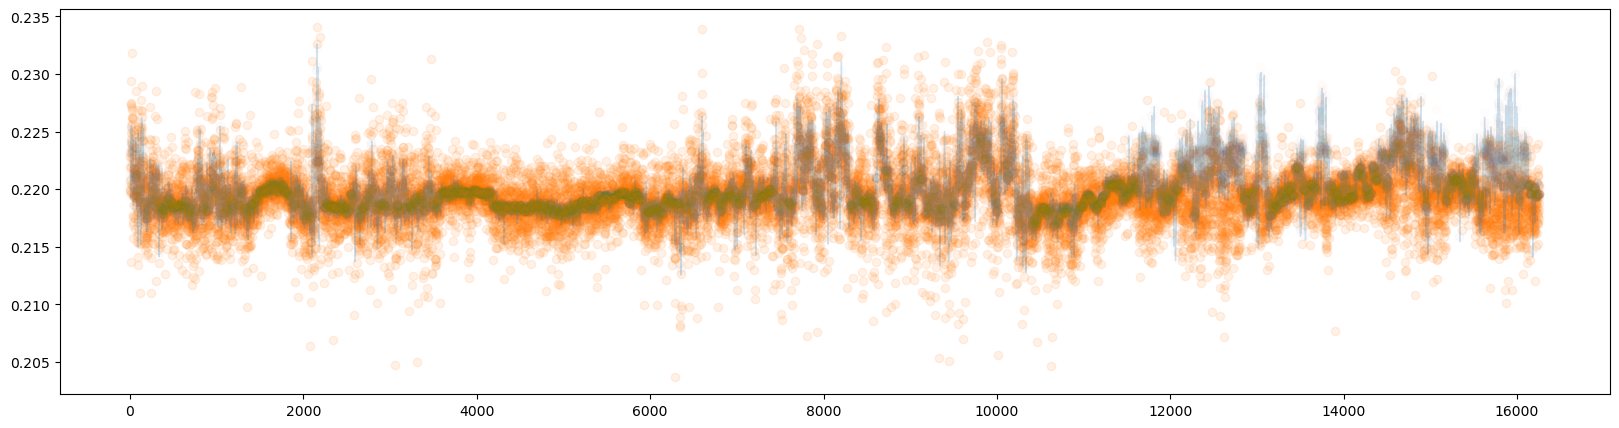

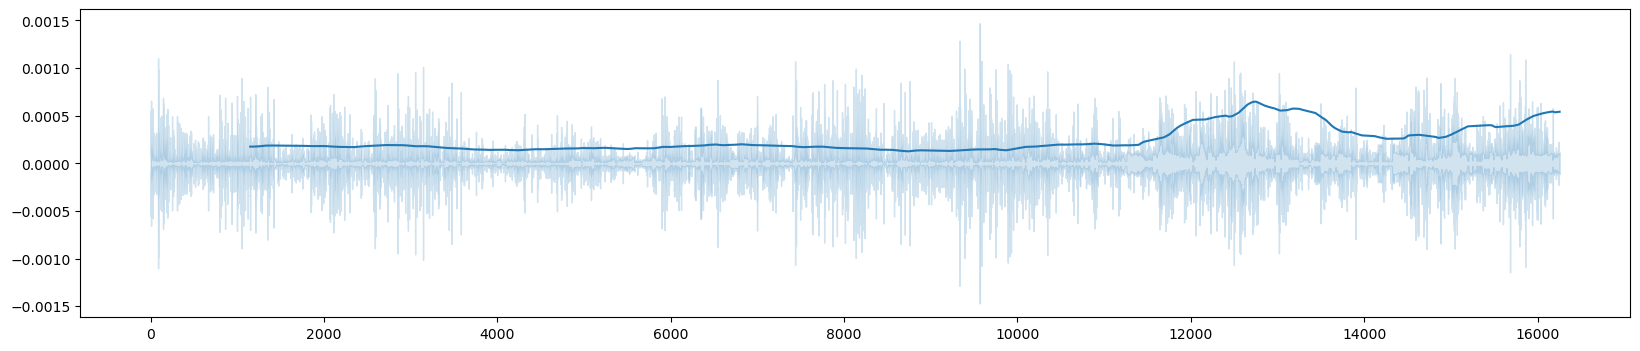

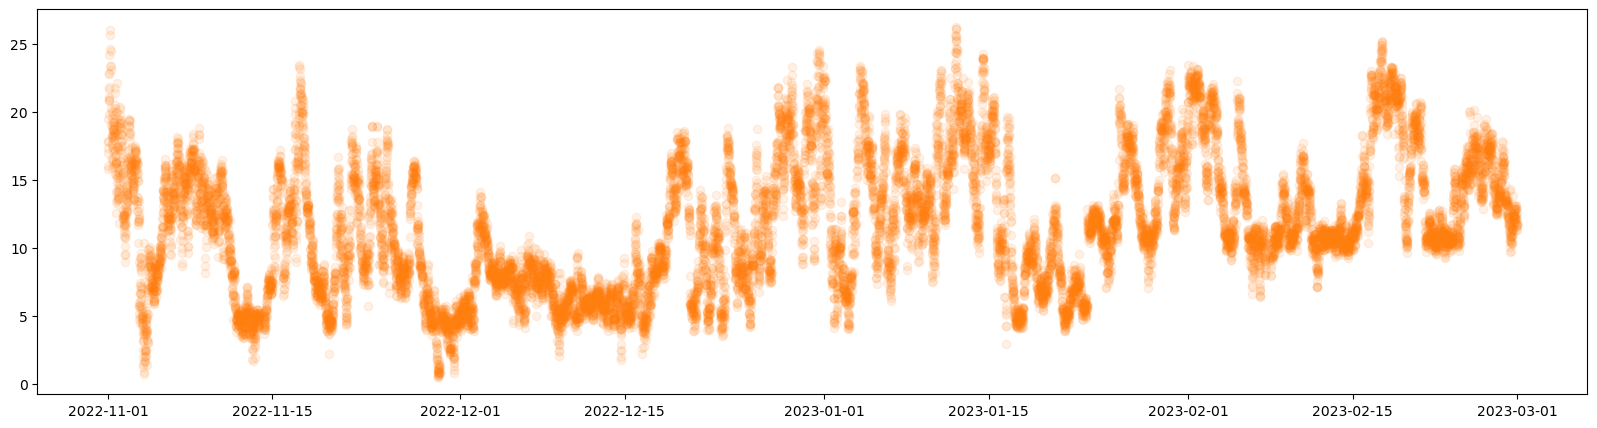

In [464]:
X_transformed = X.copy()
columns = -2
X_transformed.iloc[-5000:, columns] = X.iloc[-5000:, columns] + 6
#predictions = ensemble_model.predict(X_test*5)
mean_predictions = ensemble_model.mean_predictions(X_transformed)
std_predictions = ensemble_model.std_predictions(X_transformed)

plt.figure(figsize=(20,5))
plt.scatter(range(len(y)), y, alpha=0.1, color='tab:orange')
plt.scatter(range(len(mean_predictions)), mean_predictions, alpha=0.01)
plt.fill_between(range(len(std_predictions)), mean_predictions-std_predictions, mean_predictions+std_predictions, alpha = 0.2, color = 'tab:blue')
plt.scatter(range(len(xgb_model.predict(X_transformed))), xgb_model.predict(X_transformed), alpha=0.01)
plt.show()

plt.figure(figsize=(20,4))
#plt.scatter(range(len(y.iloc[12000:])), y.iloc[12000:], alpha=0.1, color='tab:orange')
#plt.scatter(range(len(mean_predictions)), mean_predictions, alpha=0.2)
plt.fill_between(range(len(std_predictions)), -std_predictions, +std_predictions, alpha = 0.2, color = 'tab:blue')
#plt.plot(10*pd.DataFrame(std_predictions).rolling(int(144)).min())

plt.plot(10*pd.DataFrame(std_predictions).rolling(144).min().rolling(7*144).mean())
#plt.plot(10*pd.DataFrame(std_predictions).rolling(int(7*144)).mean())
plt.show()

plt.figure(figsize=(20,5))
plt.scatter(X_transformed.index, X_transformed.iloc[:, columns], alpha=0.1, color='tab:orange')

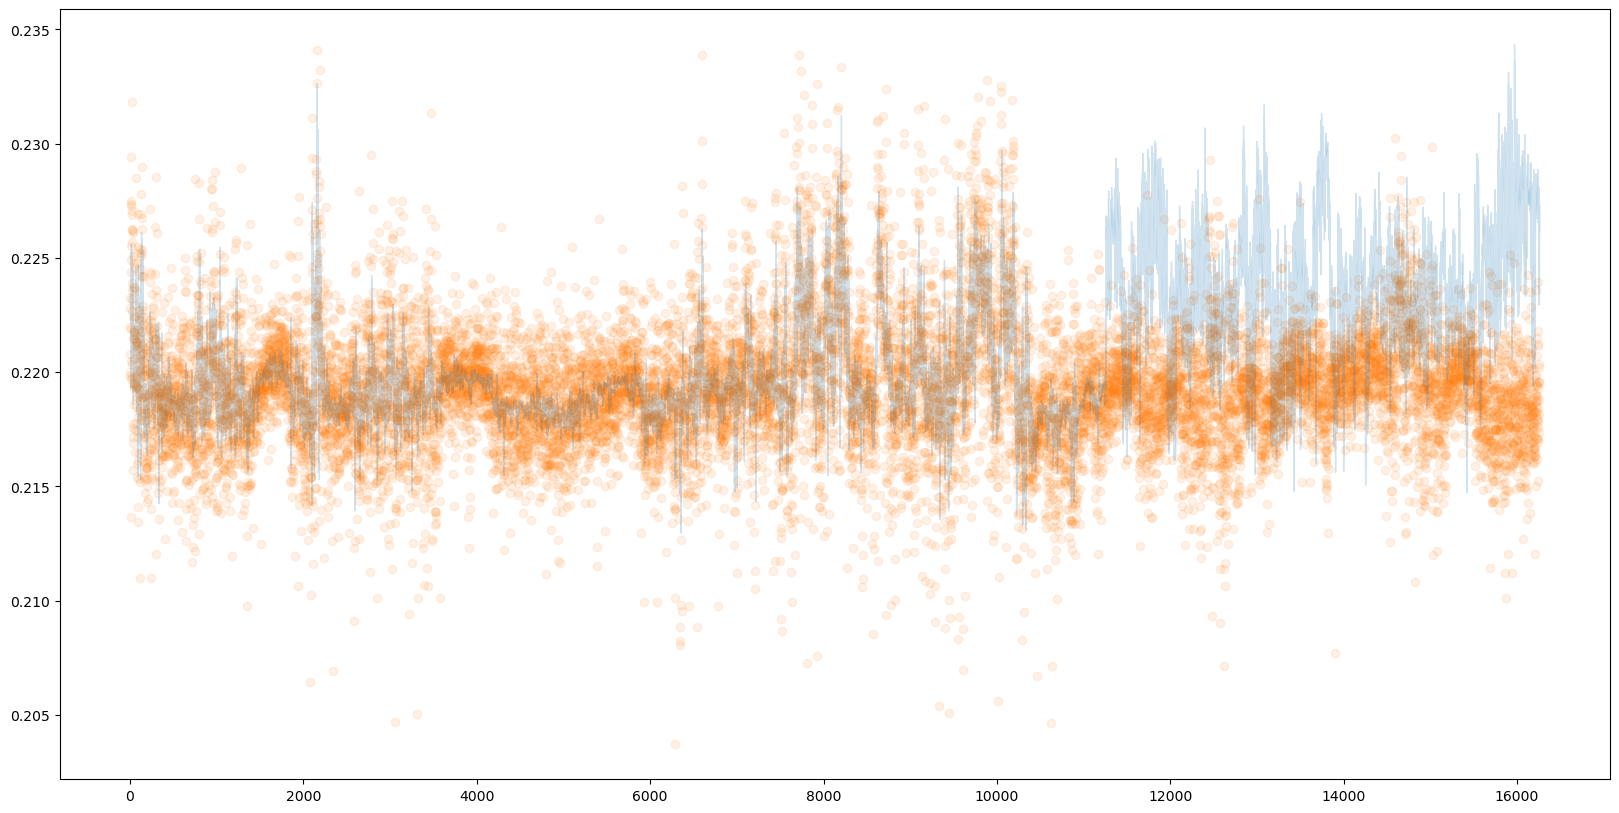

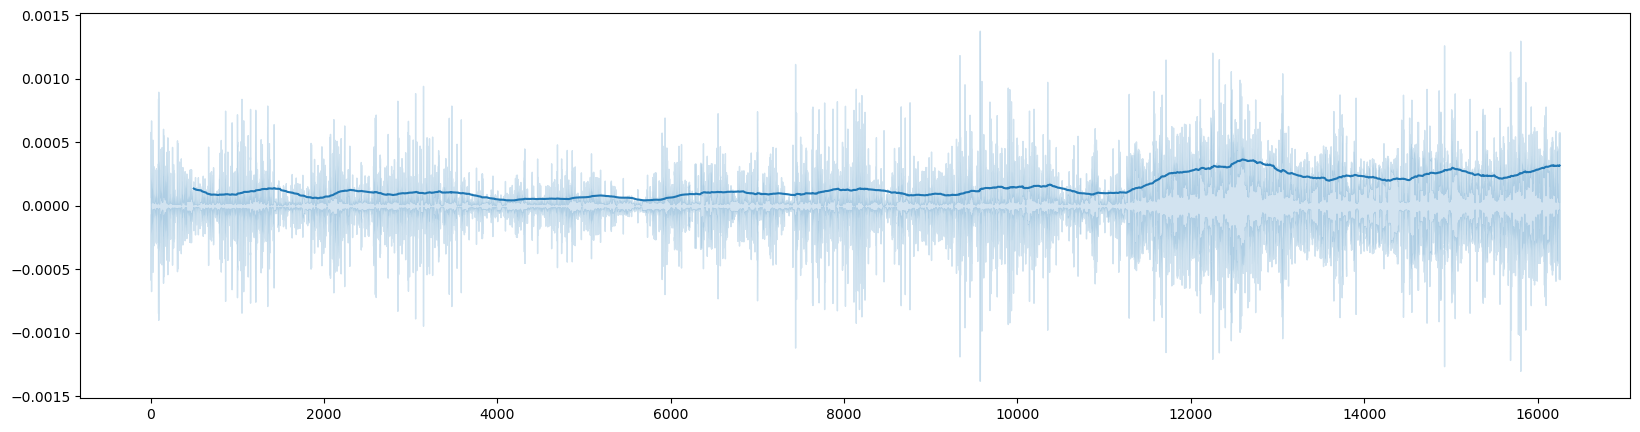

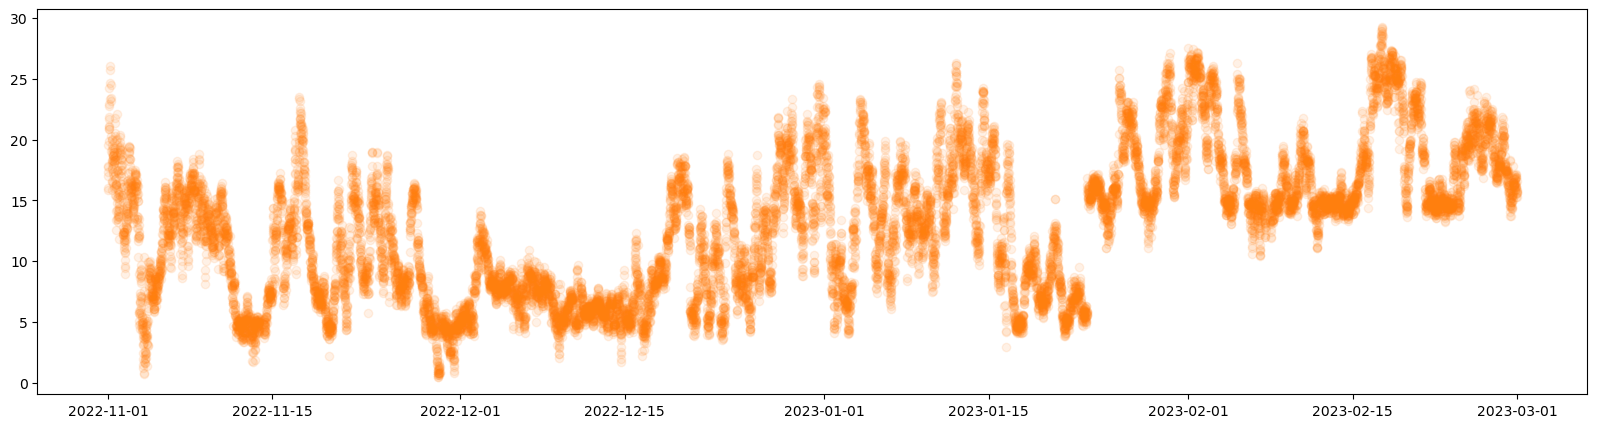

In [461]:
X_transformed = X.copy()
columns = -2
X_transformed.iloc[-5000:, columns] = X.iloc[-5000:, columns] + 10
#predictions = ensemble_model.predict(X_test*5)
mean_predictions = ensemble_model.mean_predictions(X_transformed)
std_predictions = ensemble_model.std_predictions(X_transformed)

plt.figure(figsize=(20,10))
plt.scatter(range(len(y)), y, alpha=0.1, color='tab:orange')
#plt.scatter(range(len(mean_predictions)), mean_predictions, alpha=0.2)
plt.fill_between(range(len(std_predictions)), mean_predictions-std_predictions, mean_predictions+std_predictions, alpha = 0.2, color = 'tab:blue')
plt.show()
plt.figure(figsize=(20,5))
#plt.scatter(range(len(y.iloc[12000:])), y.iloc[12000:], alpha=0.1, color='tab:orange')
#plt.scatter(range(len(mean_predictions)), mean_predictions, alpha=0.2)
plt.fill_between(range(len(std_predictions)), -std_predictions, +std_predictions, alpha = 0.2, color = 'tab:blue')
plt.plot(pd.DataFrame(std_predictions).rolling(500).mean())
plt.show()

plt.figure(figsize=(20,5))
plt.scatter(X_transformed.index, X_transformed.iloc[:, columns], alpha=0.1, color='tab:orange')

In [281]:
from ngboost import NGBRegressor

ngb = NGBRegressor().fit(X_train, y_train)
Y_preds = ngb.predict(X_test)
Y_dists = ngb.pred_dist(X_test)

[iter 0] loss=-4.4585 val_loss=0.0000 scale=1.0000 norm=0.5671
[iter 100] loss=-4.6959 val_loss=0.0000 scale=2.0000 norm=0.9635
[iter 200] loss=-4.7256 val_loss=0.0000 scale=1.0000 norm=0.4961
[iter 300] loss=-4.7409 val_loss=0.0000 scale=1.0000 norm=0.5026
[iter 400] loss=-4.7532 val_loss=0.0000 scale=1.0000 norm=0.5045


In [284]:
Y_dists

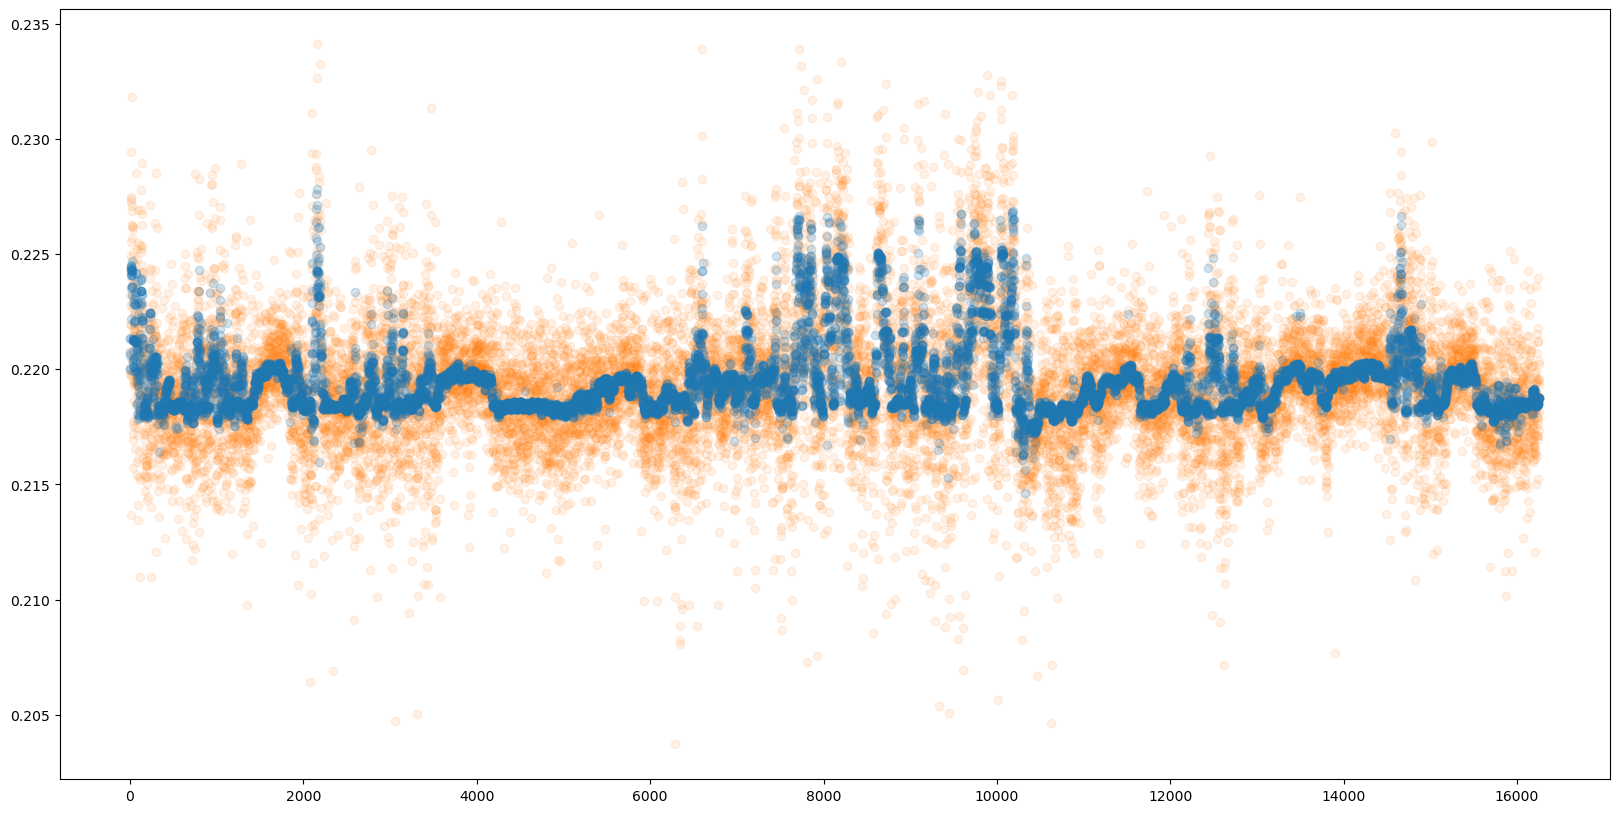

In [288]:
Y_preds = ngb.predict(X)
Y_dists = ngb.pred_dist(X)

plt.figure(figsize=(20,10))
plt.scatter(range(len(y)), y, alpha=0.1, color='tab:orange')
plt.scatter(range(len(Y_preds)), Y_preds, alpha=0.2)
#plt.fill_between(range(len(std_predictions)), mean_predictions-std_predictions, mean_predictions+std_predictions, alpha = 0.2, color = 'tab:blue')

In [277]:
X.columns

Index(['mvbc_WandelaarBuoy_Wave_height',
       'mvbc_WandelaarBuoy_Sea_water_temperature',
       'mvbc_WandelaarMeasuringpile_Tide_TAW',
       'mvbc_WandelaarMeasuringpile_Air_pressure',
       'mvbc_WandelaarMeasuringpile_Air_temperature', 'mean_NW2_D01_rpm',
       'mean_NW2_D01_yaw', 'mean_NW2_D01_pitch', 'mean_NW2_D01_power',
       'mean_NW2_D01_windspeed', 'mean_NW2_D01_winddirection'],
      dtype='object')

In [153]:
import numpy as np
from xgboost import XGBRegressor

class VirtualEnsembleXGB:
    def __init__(self, xgb_model, n_submodels):
        self.xgb_model = xgb_model
        self.n_submodels = n_submodels

    def predict(self, X):
        predictions = []
        booster = self.xgb_model.get_booster()
        total_trees = np.random.randint(1, booster.best_ntree_limit)
        print(total_trees)

        for _ in range(self.n_submodels):
            selected_tree_indices = np.random.choice(total_trees, self.n_submodels, replace=False)
            print(booster.best_ntree_limit)
            booster.trees_to_keep = selected_tree_indices
            print(booster.best_ntree_limit)
            print(selected_tree_indices)
            current_xgb = XGBRegressor()
            current_xgb._Booster = booster
            predictions.append(current_xgb.predict(X, iteration_range=(0, total_trees)))
            print(current_xgb.predict(X, iteration_range=(0, total_trees)))
        return np.array(predictions)
    
    def predict_mean(self, X):
        return self.predict(X).mean(axis=1)

    def predict_std(self, X):
        return self.predict(X).std(axis=1)

# Example usage
xgb_model = XGBRegressor(n_estimators=100)
xgb_model.fit(X, y)

n_submodels = 20
ensemble_model = VirtualEnsembleXGB(xgb_model, n_submodels)
predictions = ensemble_model.predict(X_test)

83
100
100
[20 80 59 62  2 28 32 49 42 50 26  0 69 51 61 78 41 53 71 70]
[0.21986938 0.21754335 0.22119035 ... 0.21986502 0.21923393 0.21883236]
100
100
[82 43 34 15  9 51 69 70 45 58 39  1 32 16 14 47 22 10 76 28]
[0.21986938 0.21754335 0.22119035 ... 0.21986502 0.21923393 0.21883236]
100
100
[37 46  5 22 82 19 68 28 23 16 72 53 62 35 81 64 54 24 57  0]
[0.21986938 0.21754335 0.22119035 ... 0.21986502 0.21923393 0.21883236]
100
100
[14 59 47 49 50 63 33 46 69 37 61 28 76 26 11 67 40 22 53 34]
[0.21986938 0.21754335 0.22119035 ... 0.21986502 0.21923393 0.21883236]
100
100
[80 54 46 52 78 75 27  0 64 48 62 20 38 40 60 43 55  4 28 23]
[0.21986938 0.21754335 0.22119035 ... 0.21986502 0.21923393 0.21883236]
100
100
[37  8 52 32 49 30 17 46 67 12 77 14 27 41 43 35 70 47 20 10]
[0.21986938 0.21754335 0.22119035 ... 0.21986502 0.21923393 0.21883236]
100
100
[ 9 30  8 46 10 56 82 15 12  4 41 57 17 72 61 76 31 39 36  2]
[0.21986938 0.21754335 0.22119035 ... 0.21986502 0.21923393 0.21883236]
100

In [138]:
predictions

array([[0.21988243, 0.21753603, 0.22115171, ..., 0.21992469, 0.21914081,
        0.21889421],
       [0.21988243, 0.21753603, 0.22115171, ..., 0.21992469, 0.21914081,
        0.21889421],
       [0.21988243, 0.21753603, 0.22115171, ..., 0.21992469, 0.21914081,
        0.21889421],
       ...,
       [0.21988243, 0.21753603, 0.22115171, ..., 0.21992469, 0.21914081,
        0.21889421],
       [0.21988243, 0.21753603, 0.22115171, ..., 0.21992469, 0.21914081,
        0.21889421],
       [0.21988243, 0.21753603, 0.22115171, ..., 0.21992469, 0.21914081,
        0.21889421]], dtype=float32)

In [139]:
std_predictions

array([0.00174333, 0.00174333, 0.00174333, 0.00174333, 0.00174333,
       0.00174333, 0.00174333, 0.00174333, 0.00174333, 0.00174333,
       0.00174333, 0.00174333, 0.00174333, 0.00174333, 0.00174333,
       0.00174333, 0.00174333, 0.00174333, 0.00174333, 0.00174333],
      dtype=float32)

In [140]:
mean_predictions

array([0.21941099, 0.21941099, 0.21941099, 0.21941099, 0.21941099,
       0.21941099, 0.21941099, 0.21941099, 0.21941099, 0.21941099,
       0.21941099, 0.21941099, 0.21941099, 0.21941099, 0.21941099,
       0.21941099, 0.21941099, 0.21941099, 0.21941099, 0.21941099],
      dtype=float32)

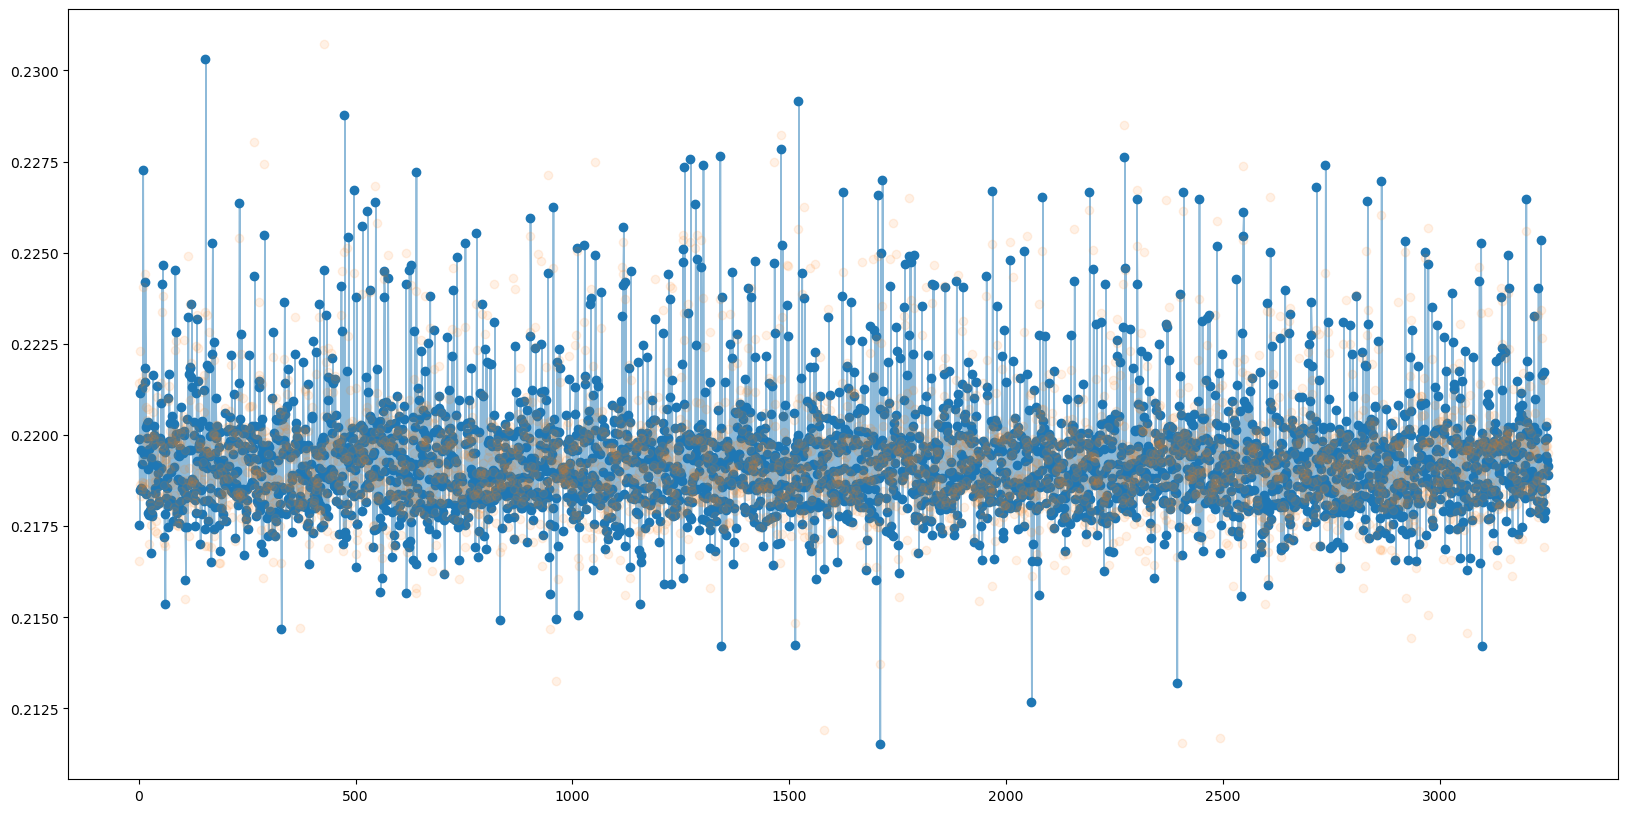

In [131]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.scatter(range(len(mean_predictions)), mean_predictions)
plt.fill_between(range(len(std_predictions)), mean_predictions-std_predictions, mean_predictions+std_predictions, alpha = 0.5, color = 'tab:blue')
plt.scatter(range(len(xgb_regressor.predict(X_test))), xgb_regressor.predict(X_test), alpha=0.1)

array([[0.21988243, 0.21753603, 0.22115171, ..., 0.21992469, 0.21914081,
        0.21889421],
       [0.21988243, 0.21753603, 0.22115171, ..., 0.21992469, 0.21914081,
        0.21889421],
       [0.21988243, 0.21753603, 0.22115171, ..., 0.21992469, 0.21914081,
        0.21889421],
       ...,
       [0.21988243, 0.21753603, 0.22115171, ..., 0.21992469, 0.21914081,
        0.21889421],
       [0.21988243, 0.21753603, 0.22115171, ..., 0.21992469, 0.21914081,
        0.21889421],
       [0.21988243, 0.21753603, 0.22115171, ..., 0.21992469, 0.21914081,
        0.21889421]], dtype=float32)

In [17]:
xgb_regressor.get_booster()

In [54]:
from xgboost import XGBRegressor
import numpy as np

class SubsampledXGBRegressor(XGBRegressor):
    def subsample_trees(self, subsample_ratio):
        # Calculate the number of trees to keep based on the subsample ratio
        num_trees = int(subsample_ratio * self.n_estimators)

        # Create a new XGBRegressor with the desired number of trees
        subsampled_model = SubsampledXGBRegressor(n_estimators=num_trees)
        subsampled_model._Booster = self.get_booster().copy()

        return subsampled_model

# Example usage
xgb_model = XGBRegressor(n_estimators=100)
xgb_model.fit(X, y)

subsample_ratio = 0.5
subsampled_model = xgb_model.subsample_trees(subsample_ratio)


AttributeError: 'XGBRegressor' object has no attribute 'subsample_trees'

In [ ]:
#generate random list of indices
def generate_random_indices(n, subsample_ratio):
    num_to_keep = int(n * subsample_ratio)
    indices = np.arange(n)
    np.random.shuffle(indices)
    return indices[:num_to_keep]

In [73]:
indices = np.arange(10)
np.random.shuffle(indices)
indices[:5]

array([3, 7, 2, 1, 6])

In [103]:
xgb_regressor.get_booster().trees_to_dataframe()

Tree  Node      ID                 Feature   Split  Yes   No Missing  \
0        0     0     0-0                    Leaf     NaN  NaN  NaN     NaN   
1        1     0     1-0                    Leaf     NaN  NaN  NaN     NaN   
2        2     0     2-0                    Leaf     NaN  NaN  NaN     NaN   
3        3     0     3-0  mean_NW2_D01_windspeed  16.514  3-1  3-2     3-1   
4        3     1     3-1                    Leaf     NaN  NaN  NaN     NaN   
...    ...   ...     ...                     ...     ...  ...  ...     ...   
7037    99   100  99-100                    Leaf     NaN  NaN  NaN     NaN   
7038    99   101  99-101                    Leaf     NaN  NaN  NaN     NaN   
7039    99   102  99-102                    Leaf     NaN  NaN  NaN     NaN   
7040    99   103  99-103                    Leaf     NaN  NaN  NaN     NaN   
7041    99   104  99-104                    Leaf     NaN  NaN  NaN     NaN   

          Gain    Cover  Category  
0    -0.084179  13004.0       NaN  
1    -0.058927  13004.0       NaN  
2    -0.041251  13004.0       NaN  
3     0.007904  13004.0       NaN  
4    -0.028988  11715.0       NaN  
...        ...      ...       ...  
7037  0.001205      3.0       NaN  
7038  0.000248     64.0       NaN  
7039  0.000012    159.0       NaN  
7040 -0.000426     11.0       NaN  
7041 -0.000001   5266.0       NaN  

[7042 rows x 11 columns]

In [92]:
from xgboost import XGBRegressor
import numpy as np

class VirtualEnsembleXGB:
    def __init__(self, n_estimators=10, subsample_ratio=0.8):
        self.n_estimators = n_estimators
        self.subsample_ratio = subsample_ratio
        self.xgb_model = XGBRegressor()
        self.models = []

    def fit(self, X, y):
        self.xgb_model.fit(X, y)
        total_features = X.shape[1]
        for _ in range(self.n_estimators):
            num_trees = np.random.randint(1, int(self.subsample_ratio * self.n_estimators))
            indices = np.arange(self.xgb_model.n_estimators)
            np.random.shuffle(indices)
            subsampled_model = XGBRegressor(n_estimators=num_trees)
            print(indices[:num_trees])
            subsampled_model._Booster = self.xgb_model.get_booster().get_dump()[indices[:num_trees]]
            self.models.append(subsampled_model)

    def predict(self, X):
        predictions = np.zeros((len(X), self.n_estimators))
        for i, model in enumerate(self.models):
            predictions[:, i] = model.predict(X)
        return predictions

    def predict_mean(self, X):
        predictions = self.predict(X)
        return np.mean(predictions, axis=1)

    def predict_std(self, X):
        predictions = self.predict(X)
        return np.std(predictions, axis=1)

In [93]:
vXGB = VirtualEnsembleXGB(n_estimators=100)
vXGB.fit(X_train, y_train)

[50 17 38 34 81 15 20 67 18 30 62 24 19 59  5  2 56 10  6 87 39  4 69 78
 23 61 54 72 43 26 75 82 64 63]


TypeError: only integer scalar arrays can be converted to a scalar index

In [52]:
vXGB.models

[XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=...depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()',
              n_estimators=array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...),
 XGBRegressor(base_sco

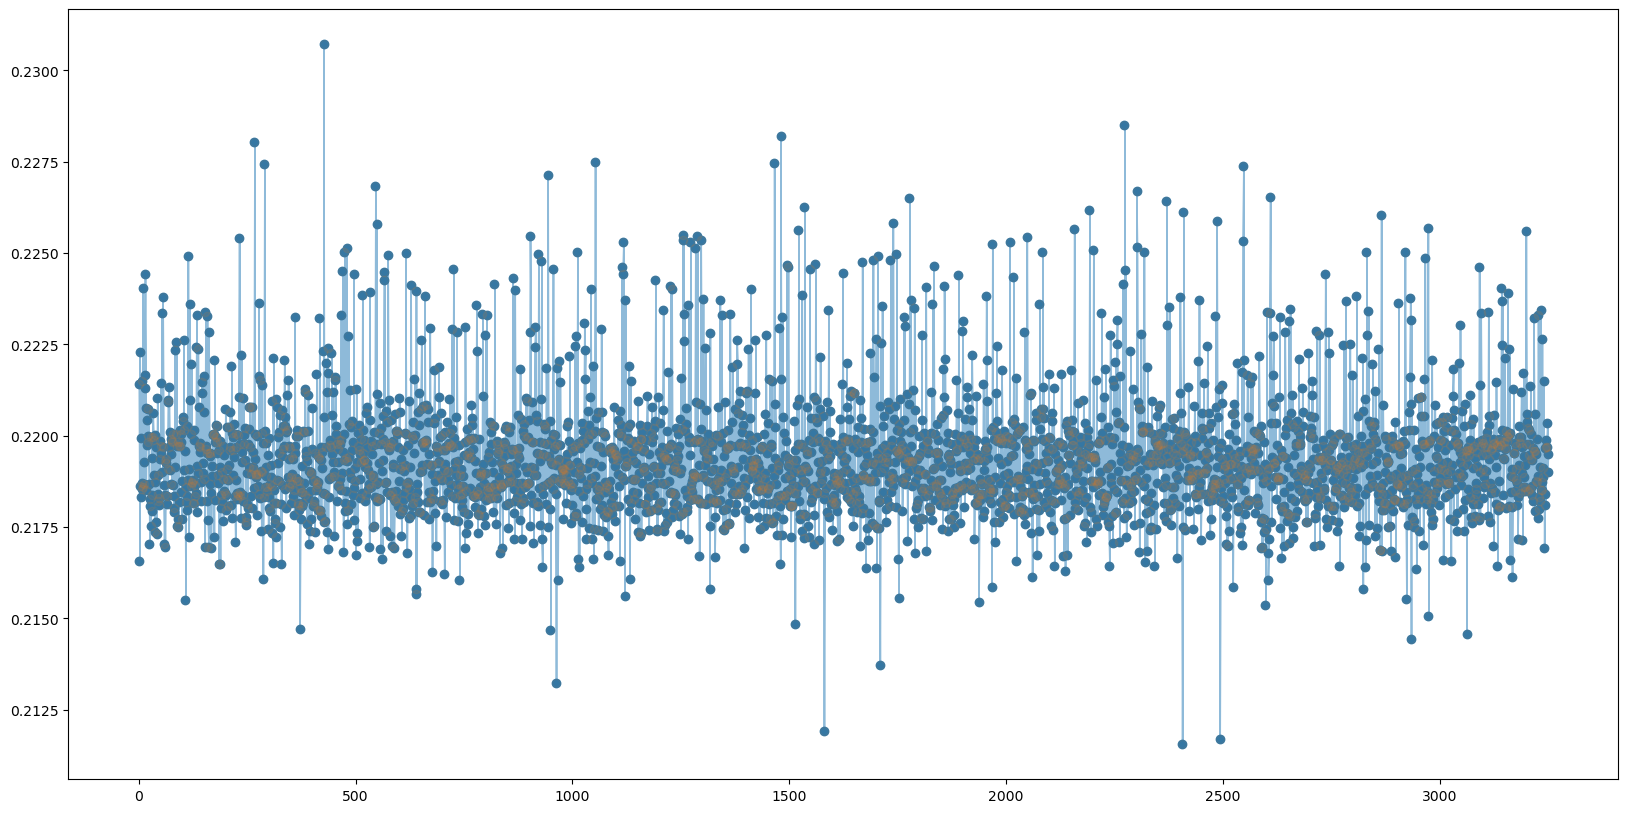

In [50]:
import matplotlib.pyplot as plt
mean_predictions = vXGB.predict_mean(X_test)
std_predictions = vXGB.predict_std(X_test)

plt.figure(figsize=(20,10))
plt.scatter(range(len(mean_predictions)), mean_predictions)
plt.fill_between(range(len(std_predictions)), mean_predictions-std_predictions, mean_predictions+std_predictions, alpha = 0.5, color = 'tab:blue')
plt.scatter(range(len(xgb_regressor.predict(X_test))), xgb_regressor.predict(X_test), alpha=0.1)